# NDTM Code setup

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from dataclasses import dataclass, field
from abc import ABC, abstractmethod
import sys
sys.path.append("/home/armand/PhD/oc-guidance/models")
sys.path.append("/home/armand/PhD/oc-guidance/")
from guided_diffusion import create_model, create_model_and_diffusion, model_and_diffusion_defaults
from utils.degredations import build_degredation_model
from utils.functions import sigmoid, get_timesteps
# load and show test_image.png
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
from math import prod
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
class DiffusionScheduleConfig:
    beta_schedule: str = 'linear'
    beta_start: float = 1e-4
    beta_end: float = 0.02
    num_diffusion_timesteps: int = 1000
    given_betas: torch.Tensor = None  # Optional, if provided, will override the schedule

class DiffusionSchedule:
    def __init__(self, hparams):
        # Instantiate the diffusion process
        if hparams.given_betas is None:
            if hparams.beta_schedule == "quad":
                betas = (
                    np.linspace(
                        hparams.beta_start**0.5,
                        hparams.beta_end**0.5,
                        hparams.num_diffusion_timesteps,
                        dtype=np.float64,
                    )
                    ** 2
                )
            elif hparams.beta_schedule == "linear":
                betas = np.linspace(
                    hparams.beta_start, hparams.beta_end, hparams.num_diffusion_timesteps, dtype=np.float64
                )
            elif hparams.beta_schedule == "const":
                betas = hparams.beta_end * np.ones(hparams.num_diffusion_timesteps, dtype=np.float64)
            elif hparams.beta_schedule == "jsd":  # 1/T, 1/(T-1), 1/(T-2), ..., 1
                betas = 1.0 / np.linspace(
                    hparams.num_diffusion_timesteps, 1, hparams.num_diffusion_timesteps, dtype=np.float64
                )
            elif hparams.beta_schedule == "sigmoid":
                betas = np.linspace(-6, 6, hparams.num_diffusion_timesteps)
                betas = sigmoid(betas) * (hparams.beta_end - hparams.beta_start) + hparams.beta_start
            else:
                raise NotImplementedError(hparams.beta_schedule)
            assert betas.shape == (hparams.num_diffusion_timesteps,)
            betas = torch.from_numpy(betas)
        else:
            betas = hparams.given_betas
        self.betas = torch.cat([torch.zeros(1).to(betas.device), betas], dim=0).cuda().float()
        self.alphas = (1 - self.betas).cumprod(dim=0).cuda().float()
            
    def alpha(self, t):
        return self.alphas.index_select(0, t+1)
    
    def beta(self, t):
        return self.betas.index_select(0, t+1)

    def predict_x_from_eps(self, xt, et, t):
        alpha_t = self.alpha(t).view(-1, 1, 1, 1)
        return (xt - et * (1 - alpha_t).sqrt()) / alpha_t.sqrt()

In [3]:
class DiffusionModel:
    def __init__(self, model: nn.Module, diffusion_schedule: object, class_cond_diffusion_model=False):
        self.model = model
        self.diffusion_schedule = diffusion_schedule
        self.class_cond_diffusion_model = class_cond_diffusion_model

    def __call__(self, xt, y, t, scale=1.0):
        y = y if self.class_cond_diffusion_model else None
        out = self.model(xt, t, y)
        et = out[:, :3]
        return et

In [193]:
class Combine_fn(ABC):
    def __init__(self, gamma_t=None):
        self.gamma_t = gamma_t

    @abstractmethod
    def forward(self, xt, ut, t=None, **kwargs):
        pass

    def __call__(self, xt, ut, t=None, **kwargs):
        return self.forward(xt, ut, t=t, **kwargs)


class Additive(Combine_fn):
    def forward(self, xt, ut, t=None, **kwargs):
        gamma_t = self.gamma_t(t) if callable(self.gamma_t) else self.gamma_t
        return xt + (gamma_t * ut if gamma_t is not None else ut)

@dataclass
class NDTMConfig:
    eta: float = 0.1
    N: int = 2  # Number of optimization steps
    gamma_t: float = 4.0  # u_t weight
    u_lr: float = 0.01  # learning rate for u_t
    combine_fn: str = "additive"  # Function to combine scores
    w_score_scheme: str = "ddim"  # Weighting scheme for score
    w_control_scheme: str = "ddim"  # Weighting scheme for score
    u_lr_scheduler: str = "linear"  # Learning rate scheduler for u_t
    init_control: str = "zero"  # Initialization scheme for u_t
    init_xT: str = "random" # Initialization scheme for x_T
    w_terminal: float = 50.0
    ancestral_sampling: bool = False  # If True, use ancestral sampling

class NDTM:
    def __init__(self, generative_model, subject_model, hparams):
        self.generative_model = generative_model
        self.diffusion = generative_model.diffusion_schedule
        self.subject_model = subject_model
        self.hparams = hparams
        self.F = self._get_combine_fn()

    def _get_combine_fn(self):
        if self.hparams.combine_fn == "additive":
            return Additive(gamma_t=self.hparams.gamma_t)

    def _get_score_weight(self, scheme, t, s, **kwargs):
        alpha_t = self.diffusion.alpha(t)
        alpha_s = self.diffusion.alpha(s)
        beta_t = self.diffusion.beta(t)
        alpha_t_im = 1 - beta_t

        if scheme == "zero":
            return torch.tensor([0.0], device=alpha_s.device)
        elif scheme == "ones":
            return torch.tensor([1.0], device=alpha_s.device) * 1.e-4
        elif scheme == "ddpm":
            return (beta_t**2) / (alpha_t_im * (1 - alpha_t))
        elif scheme == "ddim":
            c1 = (
                (1 - alpha_t / alpha_s) * (1 - alpha_s) / (1 - alpha_t)
            ).sqrt() * self.hparams.eta
            c2 = ((1 - alpha_s) - c1**2).sqrt()
            c2_ = ((alpha_s / alpha_t) * (1 - alpha_t)).sqrt()
            return (c2 - c2_) ** 2

        else:
            raise ValueError(f"Unknown scheme: {scheme}")

    def _get_control_weight(self, scheme, t, s):
        alpha_t = self.diffusion.alpha(t)
        alpha_s = self.diffusion.alpha(s)
        beta_t = self.diffusion.beta(t)
        alpha_t_im = 1 - beta_t

        if scheme == "zero":
            return torch.tensor([0.0], device=alpha_s.device)
        elif scheme == "ones":
            return torch.tensor([1.0], device=alpha_s.device) * 1.e-4
        elif scheme == "ddpm":
            return 1 / alpha_t_im
        elif scheme == "ddim":
            return alpha_t / alpha_s
        else:
            raise ValueError(f"Unknown scheme: {scheme}")

    def get_learning_rate(self, base_lr, current_step, total_steps):
        assert self.hparams.u_lr_scheduler in ["linear", "const"], \
            f"Unknown learning rate scheduler: {self.hparams.u_lr_scheduler}"
        
        if self.hparams.u_lr_scheduler == "linear":
            return base_lr * (1.0 - current_step / total_steps)
        else:  # const
            return base_lr

    def sample(self, x, y, ts, **kwargs):
        x_orig = x.clone()
        x = self.initialize(x, y, ts, **kwargs)
        y_0 = kwargs["y_0"]
        bs = x.size(0)
        xt = x

        ss = [-1] + list(ts[:-1])
        xt_s = [xt.cpu()]
        x0_s = []
        uts = []

        u_t = torch.zeros_like(xt)
        pbar = tqdm(enumerate(zip(reversed(ts), reversed(ss))), total=len(ts))
        for i, (ti, si) in pbar:

            t = torch.ones(bs).to(x.device).long() * ti
            s = torch.ones(bs).to(x.device).long() * si
            alpha_t = self.diffusion.alpha(t).view(-1, 1, 1, 1)
            alpha_s = self.diffusion.alpha(s).view(-1, 1, 1, 1)
            c1 = (
                (1 - alpha_t / alpha_s) * (1 - alpha_s) / (1 - alpha_t)
            ).sqrt() * self.hparams.eta
            c2 = ((1 - alpha_s) - c1**2).sqrt()

            # Initialize control and the optimizer
            u_t = self.initialize_ut(u_t, i)
            ut_clone = u_t.clone().detach()
            ut_clone.requires_grad = True
            current_lr = self.get_learning_rate(self.hparams.u_lr, i, len(ts))
            optimizer = torch.optim.Adam([ut_clone], lr=current_lr)

            # Loss weightings
            w_terminal = self.hparams.w_terminal
            w_score = self._get_score_weight(self.hparams.w_score_scheme, t, s, **kwargs)
            w_control = self._get_control_weight(self.hparams.w_control_scheme, t, s)

            ####################################################
            ############## Control Optimization ################
            ####################################################
            et = self.generative_model(xt, y, t).detach()
            for _ in range(self.hparams.N):
                # Guided state vector
                cxt = self.F(xt, ut_clone, t=t, **kwargs)

                # Unguided and guided noise estimates
                et_control = self.generative_model(cxt, y, t)

                # Tweedie's estimate from the guided state vector
                x0_pred = self.diffusion.predict_x_from_eps(cxt, et_control, t)
                x0_pred = torch.clamp(x0_pred, -1, 1)
                score_diff = ((et - et_control) ** 2).reshape(bs, -1).sum(dim=1)
                c_score = w_score * score_diff

                # Control loss
                control_loss = (
                    ((self.F(xt, ut_clone, t=t, **kwargs) - xt) ** 2).reshape(bs, -1).sum(dim=1)
                )
                if callable(self.hparams.gamma_t):
                    gamma_t = self.hparams.gamma_t(t)
                else:
                    gamma_t = self.hparams.gamma_t
                c_control = w_control * control_loss * (gamma_t**2)

                # Terminal Cost
                # c_terminal = ((y_0 - self.subject_model(x0_pred)) ** 2).reshape(bs, -1).sum(dim=1)
                c_terminal = torch.norm((y_0 - self.subject_model(x0_pred)), p=2).reshape(bs, -1).sum(dim=1)
                c_terminal = w_terminal * c_terminal

                # Aggregate Cost and optimize
                c_t = c_score + c_control + c_terminal

                # print(
                #     f"Diffusion step: {ti} Terminal Loss: {c_terminal.mean().item()} "
                #     f"Control loss: {c_control.mean().item()} Score loss: {c_score.mean().item()}"
                # )
                

                optimizer.zero_grad()
                c_t.sum().backward()
                optimizer.step()
            if self.hparams.N > 0:
                pbar.set_description(
                    f"Diffusion step: {ti} Terminal Loss: {c_terminal.mean().item()} "
                    f"Control loss: {c_control.mean().item()} Score loss: {c_score.mean().item()}"
            )
            ###########################################
            ############## DDIM update ################
            ###########################################
            with torch.no_grad():

                u_t = ut_clone.detach()
                cxt = self.F(xt, u_t, t=t, **kwargs)
                et_control = self.generative_model(cxt, y, t)
                
                x0_pred = self.diffusion.predict_x_from_eps(cxt, et_control, t)

                x0_pred = torch.clamp(x0_pred, -1, 1)
                if self.hparams.ancestral_sampling:
                    posterior_mean_coef1 = (
                        betas * np.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
                    )
                    posterior_mean_coef2 = (
                        (1.0 - self.alphas_cumprod_prev)
                        * np.sqrt(alphas)
                        / (1.0 - self.alphas_cumprod)
                    )
                    xt = (
                        posterior_mean_coef1 * x0_pred
                        + posterior_mean_coef2 * xt
                    )
                else:
                    xt = (
                        alpha_s.sqrt() * x0_pred
                        + c1 * torch.randn_like(xt)
                        + c2 * et_control
                    )

                uts.append(u_t.cpu())

            xt_s.append(xt.cpu())
            x0_s.append(x0_pred.cpu())

        return list(reversed(xt_s)), list(reversed(x0_s))

    def initialize_ut(self, ut, i):
        init_control = self.hparams.init_control

        if init_control == "zero":  # constant zero
            return torch.zeros_like(ut)
        elif init_control == "random":  # constant random
            return torch.randn_like(ut)
    
        elif "causal" in init_control:
            if "zero" in init_control and i == 0:  # causal_zero
                return torch.zeros_like(ut)
            elif "random" in init_control and i == 0:  # causal_random
                return torch.randn_like(ut)

            else:
                return ut

    def initialize(self, x, y, ts, **kwargs):
        """
        random: Initialization with x_T ~ N(0, 1)
        guided: Initialization with x_T ~ DDPM(H^(y_0)) - Only for Linear IP
        """
        init_scheme = self.hparams.init_xT
        
        if init_scheme == "sdedit":
            n = x.size(0)
            ti = ts[-1]
            t = torch.ones(n).to(x.device).long() * ti
            alpha_t = self.diffusion.alpha(t).view(-1, 1, 1, 1)
            return x * alpha_t.sqrt() + torch.randn_like(x) * (1 - alpha_t).sqrt()
        elif init_scheme == "guided":
            raise(NotImplementedError("Guided initialization not implemented (could be useful if subject model decoder is available)"))
            y_0 = kwargs["y_0"]
            n = x.size(0)
            x_0 = self.subject_model.decode(y_0).view(*x.size()).detach()
            ti = ts[-1]
            t = torch.ones(n).to(x.device).long() * ti
            alpha_t = self.diffusion.alpha(t).view(-1, 1, 1, 1)
            return alpha_t.sqrt() * x_0 + (1 - alpha_t).sqrt() * torch.randn_like(x_0)
        else:
            return torch.randn_like(x)


# FFHQ Reproduction

In [5]:
imagenet_config = {
    "in_channels": 3,
    "out_channels": 3,
    "num_channels": 256,
    "num_heads": 4,
    "num_res_blocks": 2,
    "attention_resolutions": "32,16,8",
    "dropout": 0.0,
    "resamp_with_conv": True,
    "learn_sigma": True,
    "use_scale_shift_norm": True,
    "use_fp16": True,
    "resblock_updown": True,
    "num_heads_upsample": -1,
    "var_type": 'fixedsmall',
    "num_head_channels": 64,
    "image_size": 256,
    "class_cond": False,
    "use_checkpoint": True,
    "use_new_attention_order": False,
    "ckpt": "imagenet_256_uncond",
}

ffhq_config = {
    "in_channels": 3,
    "out_channels": 3,
    "num_channels": 128,
    "num_heads": 4,
    "num_res_blocks": 1,
    "attention_resolutions": "16",
    "dropout": 0.0,
    "resamp_with_conv": True,
    "learn_sigma": True,
    "use_scale_shift_norm": True,
    "use_fp16": False,
    "resblock_updown": True,
    "num_heads_upsample": -1,
    "var_type": 'fixedsmall',
    "num_head_channels": 64,
    "image_size": 256,
    "class_cond": False,
    "use_new_attention_order": False,
    "ckpt": "ffhq_256",
}

diffusion_schedule_config = DiffusionScheduleConfig()
NDTM_config = NDTMConfig()

deg_config = {
    "kernel": "gaussian",
    "kernel_size": 64,
    "intensity": 3.0,
    "name": "bid",
    "lr": 0.01,
      
    "noise": { 
      "name": "gaussian",
      "sigma": 0.01,
    },
}

In [394]:
generative_model_chkpt_path = "/home/armand/PhD/FFF_fiberlearning/notebooks/GenerativeModels/ffhq_10m.pt"
base_model = create_model(**ffhq_config)
base_model.load_state_dict(torch.load(generative_model_chkpt_path, map_location=device))
base_model = base_model.to(device)

/tmp/ipykernel_3205089/2802337403.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_model.load_state_dict(torch.load(generative_model_chkpt_path, map_location=device)

In [395]:
diffusion_schedule = DiffusionSchedule(diffusion_schedule_config)
generative_model = DiffusionModel(base_model, diffusion_schedule, class_cond_diffusion_model=False)

In [402]:
@dataclass
class LoaderConfig:
    batch_size: int = 1
    num_workers: int = 12
    shuffle: bool =  False
    drop_last: bool = False
    pin_memory: bool = True

@dataclass
class DegredationConfig:
    kernel: str = "gaussian"
    kernel_size: int = 64
    intensity: float = 3.0
    name: str = "bid"
    lr: float = 0.01
    noise: dict = field(default_factory=lambda: {"name": "gaussian", "sigma": 0.01})

        
@dataclass
class DatasetConfig:
    name: str = "FFHQ_256x256"
    root: str = "/extra/ucibdl1/shared/data/ffhq_lmdb"
    split: str = "val"
    image_size: int = 256
    channels: int = 3
    transform: str = "default"
    subset: int = 1000
    decode_key: bool = False

@dataclass
class TimestepConfig:
    t_start: int = 0
    t_end: int = 600
    num_steps: int = 250
    seed: int = 0
    stride: str = "ddpm_uniform"
    root: str = "/path/to/experiment/root"
    name: str = "samples"
    ckpt_root: str = "/path/to/pretrained/checkpoints"
    samples_root: str = "/path/to/save/samples"
    overwrite: bool = True
    use_wandb: bool = False
    save_ori: bool = True
    save_deg: bool = True
    smoke_test: int = 1

@dataclass
class DegredationSubjectModelConfig:
    algo: str = "ndtm"
    deg: dict = field(default_factory=lambda: DegredationConfig())
    dataset: dict = field(default_factory=lambda: DatasetConfig())
    loader: dict = field(default_factory=lambda: LoaderConfig())
    exp: dict = field(default_factory=lambda: TimestepConfig())

class DegradationSubjectModel(nn.Module):
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        self.degredation_model = build_degredation_model(hparams)
        
    def forward(self, x):
        return self.degredation_model.H(x)

    def decode(self, y):
        return self.degredation_model.H_pinv(y)

In [403]:
subject_model = DegradationSubjectModel(hparams=DegredationSubjectModelConfig())

ndtm
deg bid


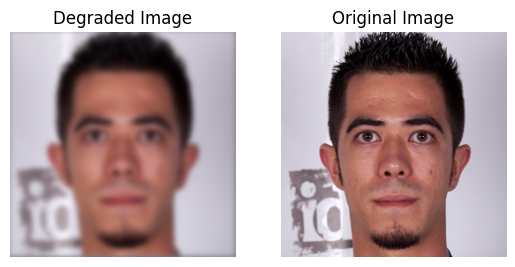

In [404]:
test_image_path = "/home/armand/ffhq_256_test_image.png"
test_image = Image.open(test_image_path).convert("RGB")
test_image = test_image.resize((256, 256))
test_image = np.array(test_image) / 255.0
test_image = torch.tensor(test_image).permute(2, 0, 1).unsqueeze(0).float().to(device) * 2 - 1  # Normalize to [-1, 1]
test_image = test_image.clamp(-1, 1)  # Ensure values are within [-1, 1]
with torch.no_grad():
    test_image_degraded = subject_model(test_image).reshape(3, 256, 256)  # Apply the degredation model
#test_image_degraded = test_image_degraded.clamp(-1, 1)  # Ensure values are within [-1, 1]
#test_image_degraded, test_image = test_image_degraded.unsqueeze(0), test_image.unsqueeze(0)

plt.subplot(1, 2, 1)
plt.imshow(test_image_degraded.squeeze().permute(1, 2, 0).cpu().numpy()/2 + 0.5)
plt.axis('off')
plt.title("Degraded Image")
plt.subplot(1, 2, 2)
plt.imshow(test_image.squeeze().permute(1, 2, 0).cpu().numpy()/2 + 0.5)
plt.axis('off')
plt.title("Original Image")
plt.show()

In [405]:
ndtm = NDTM(
    generative_model=generative_model,
    subject_model=subject_model,
    hparams=NDTM_config
)

In [406]:
ts = get_timesteps(DegredationSubjectModelConfig())
imgs_noised, imgs_approximated = ndtm.sample(test_image.to(device), None, ts, y_0 = test_image_degraded.to(device))

Diffusion step: 598 Terminal Loss: 2580522.0 Control loss: 0.0 Score loss: 0.0
Diffusion step: 598 Terminal Loss: 1135802.5 Control loss: 5094.35693359375 Score loss: 0.012198087759315968
Diffusion step: 596 Terminal Loss: 410392.71875 Control loss: 0.0 Score loss: 0.0
Diffusion step: 596 Terminal Loss: 289492.03125 Control loss: 5060.22509765625 Score loss: 0.010507969185709953
Diffusion step: 594 Terminal Loss: 200771.28125 Control loss: 0.0 Score loss: 0.0
Diffusion step: 594 Terminal Loss: 285664.78125 Control loss: 5026.25341796875 Score loss: 0.01013187225908041
Diffusion step: 592 Terminal Loss: 160500.640625 Control loss: 0.0 Score loss: 0.0
Diffusion step: 592 Terminal Loss: 274320.3125 Control loss: 4992.376953125 Score loss: 0.008734582923352718
Diffusion step: 590 Terminal Loss: 136250.828125 Control loss: 0.0 Score loss: 0.0
Diffusion step: 590 Terminal Loss: 233653.546875 Control loss: 4958.6123046875 Score loss: 0.009767021983861923
Diffusion step: 588 Terminal Loss: 119

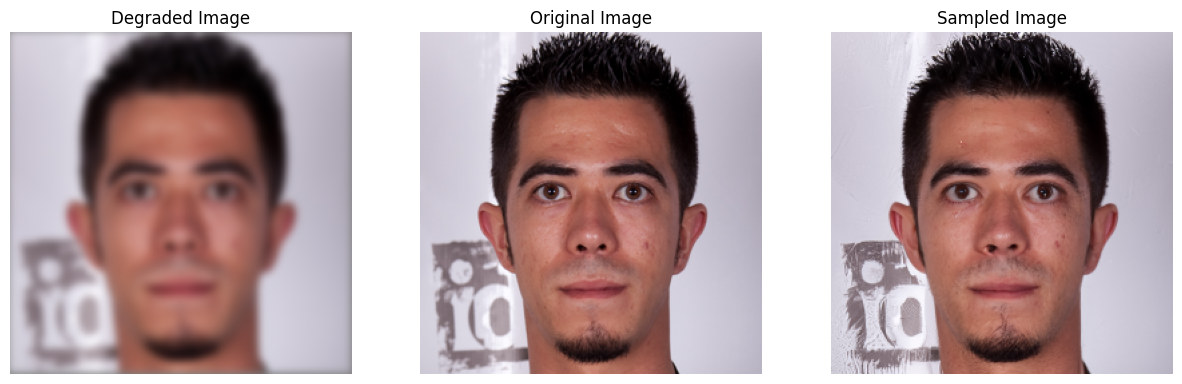

In [407]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(test_image_degraded.squeeze().permute(1, 2, 0).cpu().numpy()/2 + 0.5)
plt.axis('off')
plt.title("Degraded Image")
plt.subplot(1, 3, 2)
plt.imshow(test_image.squeeze().permute(1, 2, 0).cpu().numpy()/2 + 0.5)
plt.axis('off')
plt.title("Original Image")
plt.subplot(1, 3, 3)
plt.imshow(imgs_noised[0].squeeze().permute(1, 2, 0).cpu().numpy()/2 + 0.5)
plt.axis('off')
plt.title("Sampled Image")
plt.show()

# Dino V2 subject model on FFHQ

In [210]:
ffhq_config = {
    "in_channels": 3,
    "out_channels": 3,
    "num_channels": 128,
    "num_heads": 4,
    "num_res_blocks": 1,
    "attention_resolutions": "16",
    "dropout": 0.0,
    "resamp_with_conv": True,
    "learn_sigma": True,
    "use_scale_shift_norm": True,
    "use_fp16": False,
    "resblock_updown": True,
    "num_heads_upsample": -1,
    "var_type": 'fixedsmall',
    "num_head_channels": 64,
    "image_size": 256,
    "class_cond": False,
    "use_new_attention_order": False,
    "ckpt": "ffhq_256",
}

@dataclass
class TimestepConfig:
    t_start: int = 0
    t_end: int = 1000
    num_steps: int = 100
    seed: int = 0
    stride: str = "ddpm_uniform"
    root: str = "/path/to/experiment/root"
    name: str = "samples"
    ckpt_root: str = "/path/to/pretrained/checkpoints"
    samples_root: str = "/path/to/save/samples"
    overwrite: bool = True
    use_wandb: bool = False
    save_ori: bool = True
    save_deg: bool = True
    smoke_test: int = 1

@dataclass
class NDTMTimestepCompatability:
    exp: TimestepConfig = field(default_factory=TimestepConfig)

timestep_config = NDTMTimestepCompatability()

diffusion_schedule_config = DiffusionScheduleConfig()
NDTM_config = NDTMConfig(N=5, 
                         gamma_t= lambda t: 20 if t < 400 else 1.0 / (t/600), # torch.sigmoid((800 - t)/400) * 20.0, 
                         u_lr=0.002, 
                         w_terminal=1.0, 
                         eta=1.0,
                         u_lr_scheduler="linear",
                         w_score_scheme="zero",
                         w_control_scheme="ones")

In [211]:
class DinoSubjectModel(nn.Module):
    def __init__(self, model_name='dinov2_vitb14'):
        super().__init__()
        self.model = torch.hub.load('facebookresearch/dinov2', model_name)
        self.model.eval()  # Set to eval mode
        self.preprocess = T.Compose([
            T.Resize(256, interpolation=T.InterpolationMode.BICUBIC),
            T.CenterCrop(224),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])
        
    def forward(self, x):
        x = (x+1)/2  # Scale from [-1, 1] to [0, 1]
        x = self.preprocess(x)
        return self.model(x)

    def decode(self, y):
        raise NotImplementedError("DINOv2 does not support decoding.")

In [212]:
subject_model = DinoSubjectModel().to(device)

Using cache found in /home/armand/.cache/torch/hub/facebookresearch_dinov2_main


In [213]:
generative_model_chkpt_path = "/home/armand/PhD/FFF_fiberlearning/notebooks/GenerativeModels/ffhq_10m.pt"
base_model = create_model(**ffhq_config)
base_model.load_state_dict(torch.load(generative_model_chkpt_path, map_location=device))
base_model = base_model.to(device)

/tmp/ipykernel_3260791/2802337403.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_model.load_state_dict(torch.load(generative_model_chkpt_path, map_location=device)

In [214]:
diffusion_schedule = DiffusionSchedule(diffusion_schedule_config)
generative_model = DiffusionModel(base_model, diffusion_schedule, class_cond_diffusion_model=False)

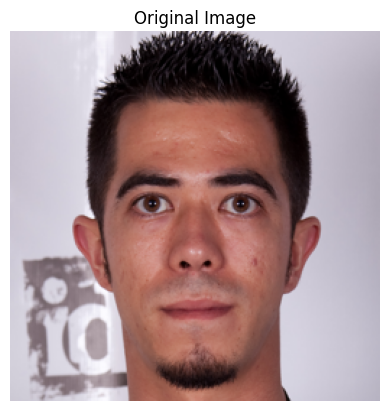

First 5 dimensions of Dino embeddings: tensor([-0.0126,  0.4392, -0.7349, -4.6978, -0.6595], device='cuda:0')


In [215]:
test_image_path = "/home/armand/ffhq_256_test_image.png"
test_image = Image.open(test_image_path).convert("RGB")
test_image = test_image.resize((256, 256))
test_image = np.array(test_image) / 255.0
test_image = torch.tensor(test_image).permute(2, 0, 1).unsqueeze(0).float().to(device) * 2 - 1  # Normalize to [-1, 1]
test_image = test_image.clamp(-1, 1)  # Ensure values are within [-1, 1]
with torch.no_grad():
    dino_features = subject_model(test_image)  # Apply the degredation model
#test_image_degraded = test_image_degraded.clamp(-1, 1)  # Ensure values are within [-1, 1]
#test_image_degraded, test_image = test_image_degraded.unsqueeze(0), test_image.unsqueeze(0)

plt.imshow(test_image.squeeze().permute(1, 2, 0).cpu().numpy()/2 + 0.5)
plt.axis('off')
plt.title("Original Image")
plt.show()

print(f"First 5 dimensions of Dino embeddings: {dino_features.squeeze()[:5]}")

In [216]:
ndtm = NDTM(
    generative_model=generative_model,
    subject_model=subject_model,
    hparams=NDTM_config
)

In [217]:
ts = get_timesteps(timestep_config)
imgs_noised, imgs_approximated = ndtm.sample(test_image.to(device), None, ts, y_0 = dino_features.to(device))

  0%|          | 0/100 [00:00<?, ?it/s]

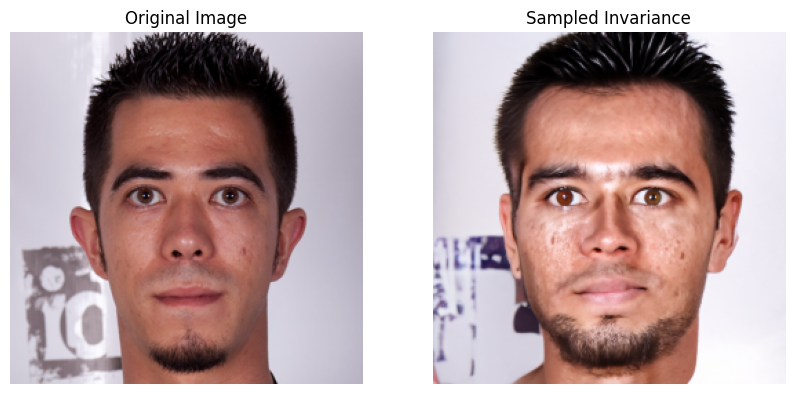

In [218]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image.squeeze().permute(1, 2, 0).cpu().numpy()/2 + 0.5)
plt.axis('off')
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(imgs_noised[0].squeeze().permute(1, 2, 0).cpu().numpy()/2 + 0.5)
plt.axis('off')
plt.title("Sampled Invariance")
plt.show()

In [219]:
dino_features_new = subject_model(imgs_noised[0].to(device))
print(f"Difference in Dino features: {torch.norm(dino_features - dino_features_new)/prod(dino_features.size())}")

Difference in Dino features: 0.006869898643344641


# Dino V2 on ImageNet

# CT Image Invariances